# Preparação de Ambiente

In [ ]:
# Conexão do Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Instalação de biblioteca
!pip install rasterio
import pandas as pd
import os
import glob
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.windows import Window
from tqdm import tqdm

#Declaração de variaveis
base = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Indices.tif"

#Define funções
def detalhes(tiff_path):
    """Exibe informações detalhadas sobre um arquivo TIFF geoespacial."""
    with rasterio.open(tiff_path) as dataset:
        print(f"📂 Arquivo: {tiff_path}")
        print(f"➡️ CRS: {dataset.crs}")  # Sistema de Coordenadas de Referência
        print(f"➡️ Resolução: {dataset.res[0]}, {dataset.res[1]}")  # Tamanho do pixel
        print(f"➡️ Dimensões: {dataset.width} x {dataset.height} (Largura x Altura)")
        print(f"➡️ Quantidade de bandas: {dataset.count}")
        print(f"➡️ Extensão: {dataset.bounds}")  # Bounding box
        print(f"➡️ Tipo de dado das bandas: {[dataset.dtypes[i] for i in range(dataset.count)]}")
        print(f"➡️ Perfil do dataset: {dataset.profile}")  # Metadados gerais
        print(f"➡️ Transformação Afim (GeoTransform): {dataset.transform}")  # Matriz de transformação espacial
        print(f"➡️ Valor NoData: {dataset.nodata}")  # Valor que representa ausência de dados
        print(f"➡️ Metadata: {dataset.meta}")  # Metadados completos

# Dicionario de cores da legenda
nova_linha = pd.DataFrame({"Class_ID": [0], "Level":[0], "Description":["none"], "Descricao":["none"], "Color": ["#404040"]})
legenda0 = pd.concat([pd.read_csv('/content/drive/MyDrive/MAPBIOMAS-EXPORT/codigos_legenda.csv', sep='\t', header=0), nova_linha], ignore_index=True)\
             .sort_values(by='Class_ID', ascending=True)\
             .reset_index(drop=True)
legenda1 = legenda0.drop(["Descricao", "Description", "Level"], axis=1)
legenda2 = legenda0.drop(["Description", "Level"], axis=1)\
                   .sort_values(by='Class_ID', ascending=True)\
                   .reset_index(drop=True)
color_dict = legenda0.set_index("Class_ID")["Color"].to_dict()

with rasterio.open(base) as src:
    band1 = src.read(18).astype(int)
unique_class_ids = sorted(set(band1.flatten()))  # Obtém todos os IDs únicos do raster
print(unique_class_ids)
palette = [
    color_dict[class_id] if class_id in color_dict else f'#404040'  # Tons de cinza
    for class_id in unique_class_ids
]
cmap3 = ListedColormap(palette)


#visualiza amostra do mapa
def visualizar_tiff_reduzido(file_path, fator_reducao=10, cmap=cmap3, canal=18):
    with rasterio.open(file_path) as src:
        # Reduz a resolução da primeira banda
        small_window = src.read(canal, out_shape=(src.height // fator_reducao, src.width // fator_reducao))
        # Exibe a imagem reduzida
        plt.figure(figsize=(10, 6))
        plt.imshow(small_window, cmap=cmap)
        # plt.colorbar()
        plt.title(f"Visualização rápida do TIFF (reduzido {fator_reducao}x)")
        plt.show()

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.1 MB/s eta 0:00:00
[3, 4, 9, 11, 12, 15, 20, 21, 24, 25, 29, 30, 33, 39, 41, 46, 48, 62]


In [ ]:
#visualiza amostra do mapa
def visualizar_tiff_reduzido(file_path, fator_reducao=10, cmap=cmap3, canal=18):
    with rasterio.open(file_path) as src:
        # Reduz a resolução da primeira banda
        small_window = src.read(canal, out_shape=(src.height // fator_reducao, src.width // fator_reducao))
        # Exibe a imagem reduzida
        plt.figure(figsize=(30, 18))
        plt.imshow(small_window, cmap=cmap)
        # plt.colorbar()
        plt.title(f"Visualização rápida do TIFF (reduzido {fator_reducao}x)")
        plt.show()

In [ ]:
# Caminho do arquivo original
base = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Indices.tif"

# Caminho para salvar o novo TIFF com a banda 24
output_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Banda24.tif"

# Definir os valores que serão 1 na nova banda
rosa_classes = {39, 20, 40, 62, 41}  # Conjunto para busca eficiente

# Abrir o arquivo original
with rasterio.open(base) as src:
    profile = src.profile  # Copiar metadados do TIFF original
    band18 = src.read(18).astype(float)  # Garantindo que seja float

# Criar a nova banda binária (mesma resolução)
banda_24 = np.isin(band18, list(rosa_classes)).astype(np.uint8)  # 1 para rosa, 0 para os demais

# Atualizar os metadados para refletir apenas uma banda
profile.update(dtype=rasterio.uint8, count=1)

# Salvar a nova banda como um arquivo TIFF separado
with rasterio.open(output_tiff, 'w', **profile) as dst:
    dst.write(banda_24, 1)  # Escrever a banda 24 como a primeira do novo arquivo

print(f"Banda 24 criada e salva em: {output_tiff}")


Banda 24 criada e salva em: /content/drive/MyDrive/Unb/Plantio_direto/TIFF_Banda24.tif


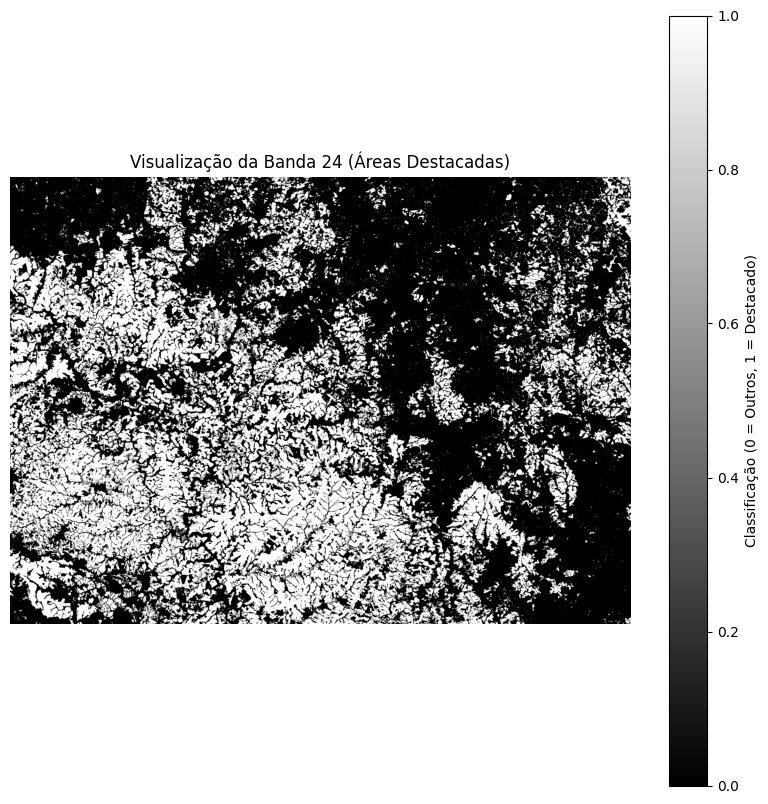

In [ ]:
# Caminho da banda 24 salva anteriormente
output_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Banda24.tif"

# Abrir o TIFF com a banda 24
with rasterio.open(output_tiff) as src:
    banda_24 = src.read(1)  # Ler a única banda presente

# Exibir a banda 24 (0 = preto, 1 = branco)
plt.figure(figsize=(10, 10))
plt.imshow(banda_24, cmap="gray")  # "gray" usa 0 = preto e 1 = branco
plt.colorbar(label="Classificação (0 = Outros, 1 = Destacado)")
plt.title("Visualização da Banda 24 (Áreas Destacadas)")
plt.axis("off")  # Esconder eixos
plt.show()


In [ ]:
# Caminho da banda 24 salva anteriormente
output_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Banda24.tif"

# Abrir a banda 24 para leitura
with rasterio.open(output_tiff) as src:
    banda_24 = src.read(1)  # Ler a única banda presente
    res_x, res_y = src.res  # Obtém a resolução do pixel (largura x altura) em metros

# Calcular a área de cada pixel em km²
pixel_area_km2 = (res_x * res_y) / 1e6  # Converte de m² para km²

# Contar o número de pixels com valor 1
num_pixels_1 = np.count_nonzero(banda_24 == 1)

# Calcular a área total coberta por esses pixels
area_km2 = num_pixels_1 * pixel_area_km2

# Calcular o percentual de cobertura
total_pixels = banda_24.size  # Número total de pixels no raster
percentual_cobertura = (num_pixels_1 / total_pixels) * 100

# Exibir os resultados
print(f"Percentual de cobertura: {percentual_cobertura:.2f}%")

Percentual de cobertura: 37.39%


In [ ]:
# Caminho do arquivo TIFF
base = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Indices.tif"

# Dicionário de cores da legenda
nova_linha = pd.DataFrame({"Class_ID": [0.0], "Level": [0], "Description": ["none"], "Descricao": ["none"], "Color": ["#404040"]})

# Carregar legenda e garantir que Class_ID seja float
legenda0 = pd.concat([
    pd.read_csv('/content/drive/MyDrive/MAPBIOMAS-EXPORT/codigos_legenda.csv', sep='\t', header=0),
    nova_linha
], ignore_index=True).astype({"Class_ID": float})  # <- Aqui convertemos para float

# Criar dicionário de cores com Class_ID como float
color_dict = legenda0.set_index("Class_ID")["Color"].to_dict()

# Abrir o arquivo TIFF e ler a banda 18
with rasterio.open(base) as src:
    band1 = src.read(18)

# Garantir que os valores extraídos são float para casar com o color_dict
unique_class_ids = sorted(set(band1.flatten().astype(float)))  # <- Aqui garantimos que seja float

print("Valores únicos na banda 18:", unique_class_ids)

# Criar paleta de cores
palette = [
    color_dict[class_id] if class_id in color_dict else "#404040"  # Cinza para valores ausentes
    for class_id in unique_class_ids
]

# Criar colormap
cmap3 = ListedColormap(palette)


Valores únicos na banda 18: [3.0, 4.0, 9.0, 11.0, 12.0, 15.0, 20.0, 21.0, 24.0, 25.0, 29.0, 30.0, 33.0, 39.0, 41.0, 46.0, 48.0, 62.0]


In [ ]:
tiff_path = base

with rasterio.open(tiff_path) as dataset:
    # Tenta acessar descrições das bandas
    band_names = dataset.descriptions

    # Exibe os nomes (se existirem)
    for i, name in enumerate(band_names, start=1):
        print(f"Banda {i}: {name if name else 'Sem nome definido'}")


Banda 1: B1 - Coastal/Aerosol
Banda 2: B2 - Azul
Banda 3: B3 - Verde
Banda 4: B4 - Vermelho
Banda 5: B5 - NIR (Infravermelho próximo)
Banda 6: B6 - SWIR1 (Infravermelho de onda curta 1)
Banda 7: B7 - SWIR2 (Infravermelho de onda curta 2)
Banda 8: B8 - Pan (Pancromática)
Banda 9: B9 - Cirrus
Banda 10: B10 - TIR1 (Infravermelho térmico 1)
Banda 11: B11 - TIR2 (Infravermelho térmico 2)
Banda 12: QA_PIXEL - Qualidade do pixel
Banda 13: QA_RADSAT - Saturação radiométrica
Banda 14: SAA - Ângulo azimutal do sol
Banda 15: SZA - Ângulo zenital do sol
Banda 16: VAA - Ângulo azimutal do sensor
Banda 17: VZA - Ângulo zenital do sensor
Banda 18: LULC Label - Classificação do uso do solo
Banda 19: NDVI - Índice de vegetação por diferença normalizada
Banda 20: EVI - Índice de vegetação melhorado
Banda 21: NDWI - Índice de água por diferença normalizada
Banda 22: NDSI - Índice de neve por diferença normalizada
Banda 23: MSAVI - Índice de vegetação ajustado para solo


In [ ]:
# Caminhos dos arquivos
base_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Indices.tif"
banda_24_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Banda24.tif"
output_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Modificado_v2.tif"

# Dicionário com as descrições corretas
descricoes_bandas = [
    "B1 - Coastal/Aerosol",
    "B2 - Azul",
    "B3 - Verde",
    "B4 - Vermelho",
    "B5 - NIR (Infravermelho próximo)",
    "B6 - SWIR1 (Infravermelho de onda curta 1)",
    "B7 - SWIR2 (Infravermelho de onda curta 2)",
    "B8 - Pan (Pancromática)",
    "B9 - Cirrus",
    "B10 - TIR1 (Infravermelho térmico 1)",
    "B11 - TIR2 (Infravermelho térmico 2)",
    "B19 - NDVI - Índice de vegetação por diferença normalizada",
    "B20 - EVI - Índice de vegetação melhorado",
    "B21 - NDWI - Índice de água por diferença normalizada",
    "B22 - NDSI - Índice de neve por diferença normalizada",
    "B23 - MSAVI - Índice de vegetação ajustado para solo",
    "B24 - Máscara de áreas de interesse"
]

# Abrir o TIFF original
with rasterio.open(base_tiff) as src:
    bandas_originais = src.read()  # Ler todas as bandas
    perfil = src.profile.copy()  # Copiar metadados

# Abrir a Banda 24 separadamente
with rasterio.open(banda_24_tiff) as src_b24:
    banda_24 = src_b24.read(1)  # Ler a única banda presente

# Selecionar apenas as bandas a serem mantidas (índices em Python começam do 0)
bandas_mantidas_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 18, 19, 20, 21, 22]  # Índices das bandas que ficam
bandas_mantidas = bandas_originais[bandas_mantidas_idx]  # Filtrar bandas

# Adicionar a Banda 24 no final
bandas_finais = np.vstack([bandas_mantidas, banda_24[np.newaxis, :, :]])

# Atualizar metadados para o novo número de bandas
perfil.update(count=bandas_finais.shape[0], dtype='float32')

# Salvar novo TIFF com as bandas e descrições corrigidas
with rasterio.open(output_tiff, 'w', **perfil) as dst:
    dst.write(bandas_finais)
    dst.descriptions = tuple(descricoes_bandas)  # Adicionar descrições às bandas

print(f"Novo arquivo salvo em: {output_tiff}")
print(f"Número de bandas finais: {bandas_finais.shape[0]}")
print(f"Descrições das bandas corrigidas:")
for i, desc in enumerate(descricoes_bandas, start=1):
    print(f"Banda {i}: {desc}")


Novo arquivo salvo em: /content/drive/MyDrive/Unb/Plantio_direto/TIFF_Modificado_v2.tif
Número de bandas finais: 17
Descrições das bandas corrigidas:
Banda 1: B1 - Coastal/Aerosol
Banda 2: B2 - Azul
Banda 3: B3 - Verde
Banda 4: B4 - Vermelho
Banda 5: B5 - NIR (Infravermelho próximo)
Banda 6: B6 - SWIR1 (Infravermelho de onda curta 1)
Banda 7: B7 - SWIR2 (Infravermelho de onda curta 2)
Banda 8: B8 - Pan (Pancromática)
Banda 9: B9 - Cirrus
Banda 10: B10 - TIR1 (Infravermelho térmico 1)
Banda 11: B11 - TIR2 (Infravermelho térmico 2)
Banda 12: B19 - NDVI - Índice de vegetação por diferença normalizada
Banda 13: B20 - EVI - Índice de vegetação melhorado
Banda 14: B21 - NDWI - Índice de água por diferença normalizada
Banda 15: B22 - NDSI - Índice de neve por diferença normalizada
Banda 16: B23 - MSAVI - Índice de vegetação ajustado para solo
Banda 17: B24 - Máscara de áreas de interesse


In [ ]:
import rasterio
import numpy as np

# Caminhos dos arquivos
input_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Modificado_v2.tif"
output_tiff = "/content/drive/MyDrive/Unb/Plantio_direto/TIFF_Modificado_v3.tif"

# Intervalo do EVI compatível com solo descoberto ou coberto por palha
EVI_MIN = 0.0  # Ajuste conforme necessário
EVI_MAX = 0.3  # Ajuste conforme necessário

# Abrir o arquivo original
with rasterio.open(input_tiff) as src:
    profile = src.profile.copy()  # Copiar metadados
    evi_band = src.read(13)  # Supondo que a Banda 13 seja o EVI
    lulc_band = src.read(17)  # Banda 17 usada como máscara

    # Criar nova banda binária (1 para compatível, 0 para não compatível)
    new_band = np.where(
        (lulc_band == 1) & ((evi_band >= EVI_MIN) & (evi_band <= EVI_MAX)),
        1,
        0
    ).astype(np.float32)

    # Atualizar metadados para incluir a nova banda
    profile.update(count=src.count + 1, dtype=np.float32, nodata=0)

    # Escrever o novo arquivo TIFF
    with rasterio.open(output_tiff, 'w', **profile) as dst:
        # Copiar todas as bandas originais
        for i in range(1, src.count + 1):
            dst.write(src.read(i), i)

        # Adicionar a nova banda
        dst.write(new_band, src.count + 1)

        # Copiar descrições e adicionar descrição da nova banda
        descriptions = list(src.descriptions) + ["Compatibilidade com manejo de plantio direto"]
        dst.descriptions = tuple(descriptions)

print("✅ TIFF atualizado com nova banda corrigida e descrições preservadas!")


✅ TIFF atualizado com nova banda corrigida e descrições preservadas!


📂 Arquivo: /content/drive/MyDrive/Unb/Plantio_direto/TIFF_Modificado_v3.tif
➡️ CRS: EPSG:4326
➡️ Resolução: 0.00026949458523585647, 0.00026949458523585647
➡️ Dimensões: 8192 x 5918 (Largura x Altura)
➡️ Quantidade de bandas: 18
➡️ Extensão: BoundingBox(left=-50.91695946153654, bottom=-18.298951832099892, right=-48.709259819284405, top=-16.704082876674093)
➡️ Tipo de dado das bandas: ['float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32']
➡️ Perfil do dataset: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 8192, 'height': 5918, 'count': 18, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EA

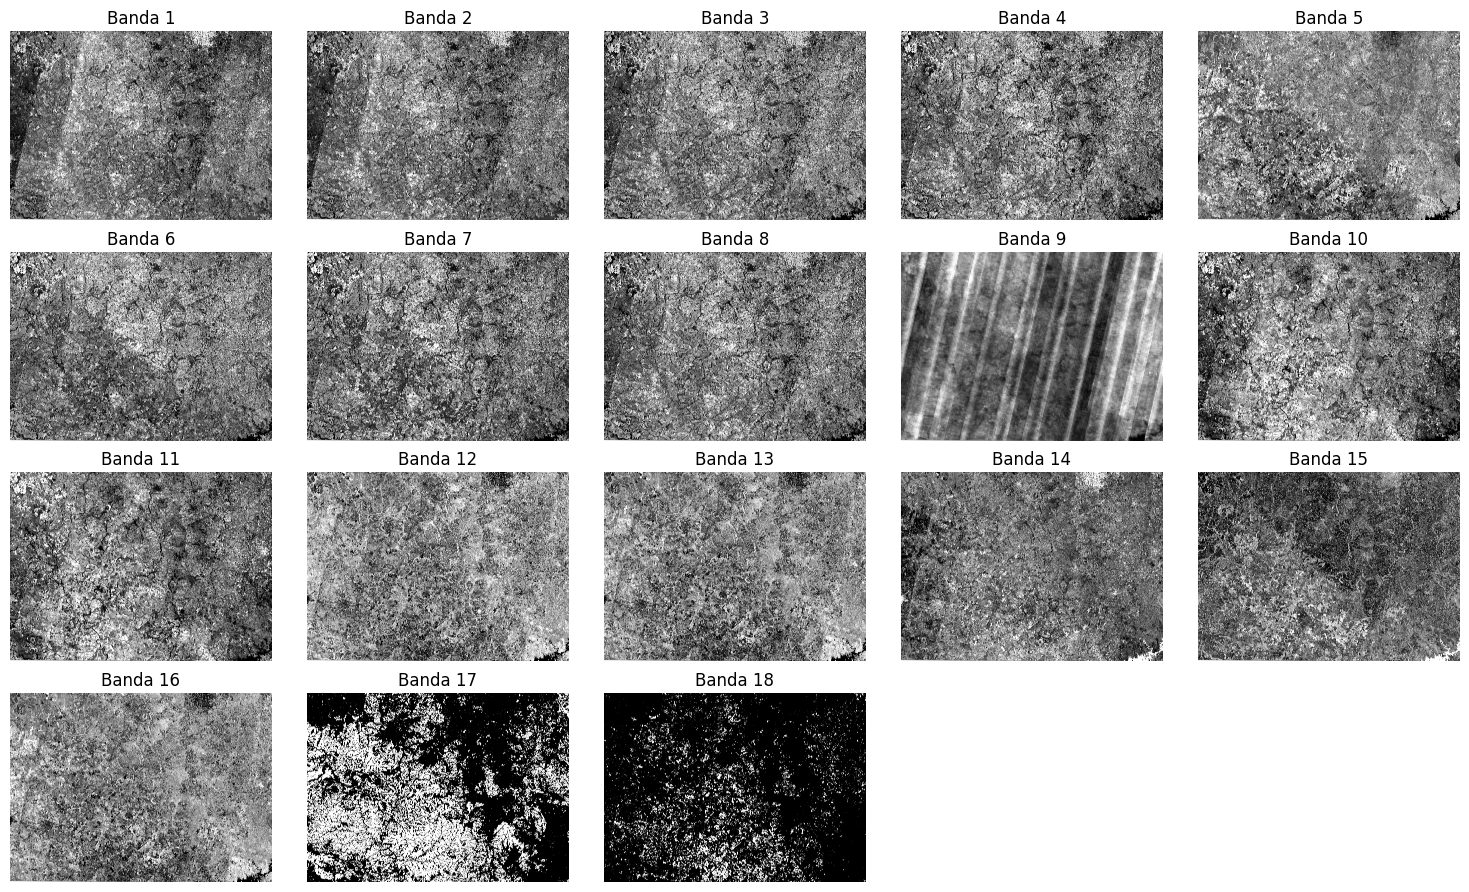

In [ ]:
detalhes(output_tiff)
tiff_path = output_tiff
with rasterio.open(tiff_path) as dataset:
    # Tenta acessar descrições das bandas
    band_names = dataset.descriptions

    # Exibe os nomes (se existirem)
    for i, name in enumerate(band_names, start=1):
        print(f"Banda {i}: {name if name else 'Sem nome definido'}")

# Abrindo o arquivo TIFF
with rasterio.open(tiff_path) as src:
    num_bands = src.count  # Quantidade de bandas
    fig, axes = plt.subplots(nrows=(num_bands // 5) + 1, ncols=5, figsize=(15, (num_bands // 5) * 3))

    for i in range(num_bands):
        band = src.read(i + 1)  # Lendo a banda (começa do 1)

        # Normalizando para visualização
        band = band.astype(np.float32)
        band_min, band_max = np.nanpercentile(band, [2, 98])  # Removendo outliers
        band = np.clip((band - band_min) / (band_max - band_min + 1e-6), 0, 1)

        # Selecionando eixo correto na grade
        ax = axes[i // 5, i % 5] if num_bands > 5 else axes[i]
        ax.imshow(band, cmap='gray')
        ax.set_title(f"Banda {i+1}")
        ax.axis("off")

    # Removendo eixos vazios, se houver
    for j in range(i+1, len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


In [ ]:
# Abrir a banda 24 para leitura
with rasterio.open(output_tiff) as src:
    banda_24 = src.read(18)  # Ler a única banda presente
    res_x, res_y = src.res  # Obtém a resolução do pixel (largura x altura) em metros

# Calcular a área de cada pixel em km²
pixel_area_km2 = (res_x * res_y) / 1e6  # Converte de m² para km²

# Contar o número de pixels com valor 1
num_pixels_1 = np.count_nonzero(banda_24 == 1)

# Calcular a área total coberta por esses pixels
area_km2 = num_pixels_1 * pixel_area_km2

# Calcular o percentual de cobertura
total_pixels = banda_24.size  # Número total de pixels no raster
percentual_cobertura = (num_pixels_1 / total_pixels) * 100

# Exibir os resultados
print(f"Percentual de cobertura: {percentual_cobertura:.2f}%")

Percentual de cobertura: 10.63%
